In [1]:
import os
import pandas as pd
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm  
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt



In [2]:
transform = transforms.Compose([
    transforms.Resize((60, 80)),
    transforms.Grayscale(num_output_channels=3),  # Convert to RGB
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Define a custom dataset class
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.labels_df = pd.read_csv(csv_file, header=None)
        self.root_dir = root_dir
        self.transform = transform
        self.label_encoder = LabelEncoder()
        self.labels_df[1] = self.label_encoder.fit_transform(self.labels_df[1])

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.labels_df.iloc[idx, 0])
        image = Image.open(img_name)
        label = torch.tensor(self.labels_df.iloc[idx, 1], dtype=torch.long)  # Convert label to tensor

        if self.transform:
            image = self.transform(image)

        return image, label

# Create custom dataset
dataset = CustomDataset(csv_file='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/labels.txt', root_dir='/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/images', transform=transform)

# Load the trained model for prediction
model = torchvision.models.resnet50(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(dataset.label_encoder.classes_))
model.load_state_dict(torch.load( '/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/models/torch.pth'))
model.eval()



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [23]:
# Define function to predict category of a query image
def predict_category(image_path):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)
        predicted_label = dataset.label_encoder.inverse_transform([predicted.item()])  # Convert to list
    return predicted_label[0]

def extract_colors(image_path, num_colors=5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise and improve contour detection
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Binary thresholding
    _, binary_thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find contours from the binary threshold image
    contours, hierarchy = cv2.findContours(binary_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create a mask for the largest contour
    mask = np.zeros_like(gray)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        # Fill the largest contour to create a solid shape
        cv2.drawContours(mask, [largest_contour], -1, color=255, thickness=cv2.FILLED)

    # Apply the mask to the original image
    masked_image = cv2.bitwise_and(image, image, mask=mask)

    # Extract the masked area for color analysis
    # Get indices where mask is not zero (i.e., inside the contour)
    idx = np.where(mask != 0)
    pixels = image[idx[0], idx[1], :]

    # Apply K-means clustering to find dominant colors
    kmeans = KMeans(n_clusters=num_colors)
    kmeans.fit(pixels)
    colors = kmeans.cluster_centers_

    # Get the labels assigned to each pixel
    labels = kmeans.labels_

    # Count the occurrences of each label
    counts = np.bincount(labels)

    return colors.astype(int), masked_image, counts



#COVERT RGB TO HEX
def rgb_to_hex(rgb):
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])


def display_colors_sorted(colors,counts):
    # Create a square image with the sorted colors
    sorted_indices = np.argsort(counts)[::-1]
    sorted_colors = [colors[i] for i in sorted_indices]
    color_img = np.zeros((100, len(sorted_colors)*100, 3), dtype=np.uint8)
    for i, color in enumerate(sorted_colors):
        color_img[:, i*100:(i+1)*100] = color
        hex_color = rgb_to_hex(color)
    
    plt.imshow(color_img)
    plt.axis('off')
    plt.show()
    
    return sorted_colors  # Return the sorted colors for further use


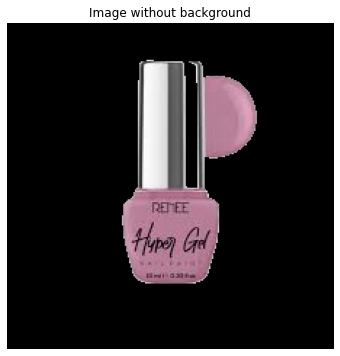



Predicted category for query image: Personal Care




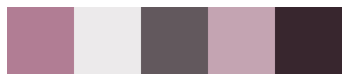

In [25]:
# Example
query_image_path = "/home/jovyan/efs/users/Shreya_Sivakumar/TASK_1/data/nail.jpeg"  # Full path to the image file

colors, masked_image, counts = extract_colors(query_image_path)

# Display the image without background
plt.figure(figsize=(6, 6))
plt.imshow(masked_image)
plt.title("Image without background")
plt.axis('off')
plt.show()

predicted_category = predict_category(query_image_path)
print("\n")
print(f"Predicted category for query image: {predicted_category}")
print("\n")
sorted_colors = display_colors_sorted(colors,counts)